# Tensorflow Similarity Advanced colab

Before using this colab -- please refers to[]

## Notebook goal
We are going to demonstrate:
1.
2.

## References
- Start here

Send feeback to elieb@  - code: [private github (ask for access)](https://github.com/tensorflow/similarity)

# colab emphase
- metrics (removed from hellowred)
- callbacks
- custom threshold
- tf.dataset usage

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Required to load the stanford_dogs dataset
# This will install scipy in your current pyenv.
import sys
!{sys.executable} -m pip install scipy tensorflow_datasets

In [3]:
import collections
import os
import re
import functools
from time import time
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.core.utils import read_config as read_config_lib
from tensorflow_datasets.core import tfrecords_reader
from tensorflow_datasets.core import file_adapters
from tensorflow.keras import layers
from tensorflow.keras import applications
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from time import time
from tabulate import tabulate
from matplotlib.pyplot import imshow
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from pathlib import Path

In [4]:
import tensorflow_similarity as tfsim
from tensorflow_similarity.utils import tf_cap_memory
from tensorflow_similarity.losses import TripletLoss  # specialized loss
from tensorflow_similarity.layers import MetricEmbedding # layer with l2 regularization
from tensorflow_similarity.models import SimilarityModel # TF model with additional features
from tensorflow_similarity.distance_metrics import avg_neg, avg_pos, dist_gap, max_pos, min_neg  # various metrics on how the distance between examples evolve.
from tensorflow_similarity.callbacks import EvalCallback  # evaluate matching performance
# from tensorflow_similarity.callbacks import SplitValidationLoss # evaluate validation loss on known and unknown classes
from tensorflow_similarity.samplers import MultiShotMemorySampler  # sample data
from tensorflow_similarity.samplers import TFRecordDatasetSampler
from tensorflow_similarity.samplers import select_examples  # select n example per class
from tensorflow_similarity.visualization import viz_neigbors_imgs  # Neigboors vizualisation
from tensorflow_similarity.visualization import confusion_matrix  # matching performance

In [5]:
# make sure TF don't blew up
tf_cap_memory()
print('TensorFlow:', tf.__version__)
print('TensorFlow Similarity', tfsim.__version__)

TensorFlow: 2.4.1
TensorFlow Similarity 0.12.0


# Data preparation

We are going to load the [Stanford Dogs](https://www.tensorflow.org/datasets/catalog/stanford_dogs) dataset and restrict our training data to only N of the 120 classes (60 by default) to showcase how the model is able to find similar examples from classes unseen during training which is one of the main reason you would want to use metric learning.


**Important**: Tensorflow similarity expect `y_train` to be the examples class as integers. Accordingly contrary to a standard classification that do categorical encoding we are leavig `y_train` as is.

In [6]:
stanford_dogs_builder = tfds.builder(name='stanford_dogs')
stanford_dogs_builder.download_and_prepare()
data_path = stanford_dogs_builder.data_path
print(f'Data Path: {data_path}')

Data Path: C:\Users\elie\tensorflow_datasets\stanford_dogs\0.2.0


In [7]:
stanford_dogs_builder.info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

# Sort Train Data by Class
The tf records need to contain contiguous blocks of classes in order for the tf record sampler to properly sample the dataset. Here we load the data, sort by class and then materialize the raw image and label.

In [32]:
IMG_SIZE = 320
MDL_IMG_SIZE = 224
INPUT_SHAPE=(IMG_SIZE, IMG_SIZE, 3)
NUM_CLASSES = 120
NUM_KNOWN_CLASSES = 100  #@param {type: "slider", min: 1, max: 120}
BATCH_SIZE = 128

classes = np.random.choice(NUM_CLASSES, size=NUM_KNOWN_CLASSES, replace=False)
# note we added 'unknown' as the 121st class
labels = [f"{i}" for i in range(NUM_CLASSES)] + ["Unknown"]

def img_decoder(image):
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize_with_crop_or_pad(image, target_height=IMG_SIZE, target_width=IMG_SIZE)
    return image

def deserialization_fn(tf_example):
    fd = {
        'image': tf.io.FixedLenFeature([], dtype=tf.string),
        'label': tf.io.FixedLenFeature([], dtype=tf.int64),
    }
    sample = tf.io.parse_single_example(tf_example, fd)
    image = img_decoder(sample['image']) 
    label = sample['label']
    
    return (image, label)

@tfds.decode.make_decoder(output_dtype=tf.float32)
def decode_wraper(image, feature):
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize_with_crop_or_pad(image,     target_height=IMG_SIZE, target_width=IMG_SIZE)
    return image


val_dataset = stanford_dogs_builder.as_dataset(
    split='test', 
    shuffle_files=True, 
    as_supervised=True,
    batch_size=BATCH_SIZE,
    decoders={'image': decode_wraper()}
)

To learn efficiently each batch must contains at least 2 sample of each class. Additionally it is often useful to have multiple examples of each class so we can mine informative triplet using different mining strategies (e.g *semi-hard* mining).

To make this easy tf_similarity offers `Samplers()` that allows to control the number of classes and minimal ammount of examples in each class. Here we are going `TFRecordDatasetSampler()` which allows us to sample a large dataset by sampling over tfrecords. We expect the examples to be in contiguous blocks in the records. The simplest way to do this is to write a record for each class.

In [9]:
# Here we:
#   * Read the raw data and add it to a dict keyed by class.
#   * Serialize the raw image byte string and the label int.
#   * Materialize a tfrecord for each key in the dict.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        # BytesList won't unpack a string from an EagerTensor.
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def to_tfrecord(img, label):
    feature = {
      'image': _bytes_feature(img),
      'label': _int64_feature(label),
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()

def to_sharded_tfrecord(ds, dspath, classes):
    shards = collections.defaultdict(list)

    # delete existing shards:
    for i in range(200):
        shard = Path(dspath) / f"stanford_dogs-train-sorted_{i}.tfrecord"
        if shard.exists():
            shard.unlink()
    # assign examples to the right shard
    sids = set()
    for example in tqdm(ds, unit='examples'):
        lbl = int(example['label'])
        if lbl in classes:
            sid = int(lbl / 10  + 10)
            shards[sid].append(example)
            sids.add(sid)

    for sid in tqdm(sids, unit='shards'):
        data = shards[sid]
        shard_path = Path(dspath) / f"stanford_dogs-train-sorted_{sid}.tfrecord"
    
        print(sid)
        with tf.io.TFRecordWriter(str(shard_path)) as writer:
            for fd in data:
                example = to_tfrecord(fd['image'], int(fd['label']))
                writer.write(example)

raw_train_data = stanford_dogs_builder.as_dataset(
    split='train', 
    shuffle_files=True,   
    decoders={'image': tfds.decode.SkipDecoding()}
)

to_sharded_tfrecord(raw_train_data, data_path, classes)

 42%|████▏     | 5/12 [00:01<00:01,  3.84shards/s]14
15
100%|██████████| 12/12 [00:03<00:00,  3.61shards/s]


In [10]:
# There are 120 tfrecords, one for each class.
# Here we take the first 60 records.
# parallelism = 120
file_parallelism = 12

sampler = TFRecordDatasetSampler(
    data_path, 
    deserialization_fn=deserialization_fn,
    batch_size=BATCH_SIZE,
    file_parallelism=file_parallelism, 
    prefetch_size=20,
    shard_suffix="*.tfrecord")

found  12 shards


# model setup

## Model definition
FIXME

## Data augmentation

In [11]:
# Create an image augmentation pipeline.
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.15),
    layers.experimental.preprocessing.RandomCrop(224, 224),
])

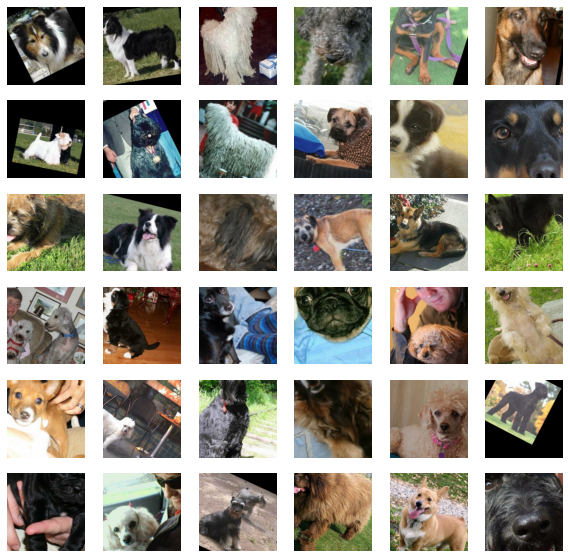

In [12]:
# FIXME: use viz_neigbors_imgs

# Examples of teh augmented images.
num_imgs = 6
si = iter(sampler)
examples = [next(si)[0] for _ in range(num_imgs**2)]
plt.figure(figsize=(10, 10))
for i in range(num_imgs**2):
    ax = plt.subplot(num_imgs, num_imgs, i + 1)
    augmented_image = data_augmentation(examples[i])
    plt.imshow(augmented_image[0] / 255)
    plt.axis("off")

## FIXME explain efficient net with ref
[Efficient Net paper](https://arxiv.org/pdf/1905.11946.pdf)

In [13]:
# Build the model using the frozen EfficientNetB0 model.
# The EfficientNetB0 expects the images to be (255, 255, 3)
# Additionally, EfficientNetB0 will scale the images to [0,1) within the model.

def get_model():
    KERNEL_INITIALIZER = {
        'class_name': 'VarianceScaling',
        'config': {
            'scale': 1. / 3.,
            'mode': 'fan_out',
            'distribution': 'uniform'
        }
    }
    
    #tf.keras.backend.clear_session()


    preprocess_input = tf.keras.applications.efficientnet.preprocess_input
    base_model = applications.EfficientNetB0(
    include_top=False,
    weights='imagenet'
    )
    #preprocess_input = tf.keras.applications.mobilenet.preprocess_input
    #base_model = tf.keras.applications.MobileNetV3Large(include_top=False, weights='imagenet')
    #base_model = tf.keras.applications.MobileNetV3Small(include_top=False, weights='imagenet')
    
    #base_model.trainable = False

    # Freeze all the layers before the the last 2 blocks
    # and don't train the batch norm layers!
    base_model.trainable = True
    for layer in base_model.layers:
        if not re.search("^block[5,6,7]|^top", layer.name) or isinstance(layer, layers.BatchNormalization):
            layer.trainable =  False


    
    # for layer in base_model.layers:
    #     print(layer.name)

    # output = base_model.get_layer(name='block3b_add')
    # base = tf.keras.Model(base_model.input, output.output)
    #base.trainable = False

    x = inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(x)
    x = preprocess_input(x)
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='swish', kernel_initializer=KERNEL_INITIALIZER)(x)
    outputs = layers.Dense(64)(x)
    return SimilarityModel(inputs, outputs)
model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
Total params: 4,221,795
Trainable params: 3,837,288
Non-trainable params: 384,507
__________________________________

## Loss definition

Overall Similarity losses (aka metric losses) are similar to other losses except they expect different inputs.

For triplet loss, one of the most popular one, you need to decide what type of triplet mining you want. Usually `hard` mining for positive example and `semi-hard` mining work well and are the default. They are passed explicitly here for reference.

The `distance` parameters specify which distance metric to use to compute the distance between embeddings. `cosine` is usually a great starting point and the default.


In [14]:
distance = 'cosine' #@param ["cosine"]{allow-input: false}
positive_mining_strategy = 'hard' #@param ["easy", "hard"]{allow-input: false}
negative_mining_strategy = 'semi-hard'  #@param ["easy", "semi-hard", "hard"]{allow-input: false}
triplet_loss = TripletLoss(distance=distance,
    positive_mining_strategy=positive_mining_strategy,
    negative_mining_strategy=negative_mining_strategy)

## Evaluation callback
TensorFlow Similarity comes with a callback that makes it easy to evaluate during training how the match rate is improving. This callback works by taking as input as set of `targets`/`target_labels` which are examples you want to match against and a set of `queries` / `query_labels` that what you want to matches.

Here we are going to use part of the test dataset as targets and another part as queries. 

Notes:

- callback only runs at epoch_end to avoid slowing down the training.
- writing to TF metrics is currently broken pending changes in TensorFlow.
- Logging to TensorBoard works - just add a `tf_logdir` path as illustrated below.


In [15]:
# num_targets = 200 #@param {type:"int"}
# num_queries = 300 #@param {type:"int"}
# k = 3 #@param {type:"int"}
# log_dir = 'logs/%d/' % (time())
# query_offset = num_targets + num_queries
# # TFsim callback for match rate
# tsc = EvalCallback(x_test[:num_targets], y_test[:num_targets], x_test[num_targets:query_offset], y_test[num_targets:query_offset], k=k, tb_logdir=log_dir)
  
# # Tensorboard callback
# tbc = TensorBoard(log_dir=log_dir)

# callbacks =[tbc, tsc]

In [16]:
# # Check the batch to class ratio. Useful for debugging.
# # TODO(ovallis): Convert this to a metric so we can track the 
# #                ratio during training.
# vi = iter(sampler)
# l_ratio = 0
# for i in range(500):
#     _, y = next(vi)
#     l_ratio += y.shape[0] / len(set(y.numpy()))
        
# print(l_ratio/500)

In [19]:
LR = 0.0001  #@param {type:"float"}
steps = 1
model = get_model()
model.compile(optimizer=Adam(LR), loss=triplet_loss, steps_per_execution=steps)

Distance metric automatically set to cosine use the distance arg to override.


In [27]:
EPOCHS = 15 #@param {type:"integer"}
STEPS_PER_EPOCH = 1000 #@param {type:"integer"}
history = model.fit(
    sampler, 
    epochs=EPOCHS, 
    steps_per_epoch=STEPS_PER_EPOCH, 
    validation_data=val_dataset, 
)

Epoch 1/5
1000/1000 [==============================] - 203s 203ms/step - loss: 0.2194 - val_loss: 0.6240
Epoch 2/5
1000/1000 [==============================] - 190s 190ms/step - loss: 0.1996 - val_loss: 0.6239
Epoch 3/5
  23/1000 [..............................] - ETA: 2:43 - loss: 0.1997

KeyboardInterrupt: 

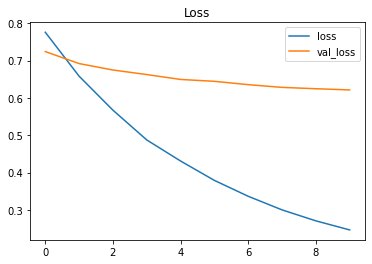

In [21]:
# expect loss: 0.05 / val_loss: 0.8
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.show()

# Indexing

Indexing is where things get different from traditional classification models. Because the model learned to output an embedding that represent the example position in a metric space and not a classification, we need a way to find which known example(s) are the closest to determine the class of the incoming data (aka nearest neighboors classication).

To do so we need to **create an index of known example from the 10 cloth classes**. We do this by taking **200 examples from the train dataset which amount to 20 examples** for each class and use the `index()` funtion of the model to build the index.

Adding more examples per class, helps increase the accuracy/generalization as you improve the set of known variations that the classifier "knows". 

Reseting the index is not necessary but it ensure we start with a clean index in case of a re-run

In [33]:
# Convert the dataset to X and y collections.
# TODO(ovallis) Provide an approach that works for large datasets  => probaby not needed.
x_train, y_train = zip(*stanford_dogs_builder.as_dataset(
    split='train', 
    as_supervised=True,
    decoders={'image': decode_wraper()}
))

In [34]:
x_index, y_index = select_examples(x_train, y_train, range(120), 20)
model.reset_index()
model.index(x_index, y_index)

[Indexing 2400 points]
|-Computing embeddings
|-Storing data points in index table
|-Adding embeddings to fast NN matcher index.
|-Optimizing NN matcher index.


# Querying

To "classify" our testing data, we need for each testing example to look for its *k* [nearest neighbors](https://scikit-learn.org/stable/modules/neighbors.html) in the index.

We query a single random example for each class from the test dataset using  `select_examples()` and then find their nearest neighboors using the `single_lookup()` function.

In [35]:
# Convert the dataset to X and y collections.
# FIXME use val_dataset ?
x_test, y_test = zip(*stanford_dogs_builder.as_dataset(
    split='test', 
    as_supervised=True,
    decoders={'image': decode_wraper()}
))

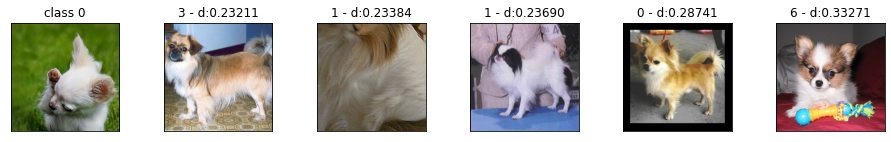

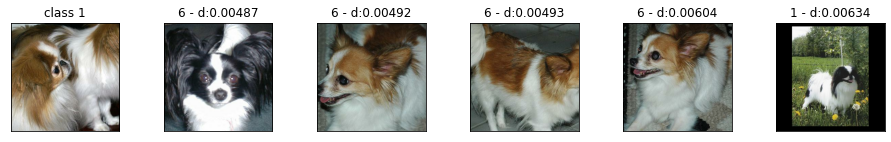

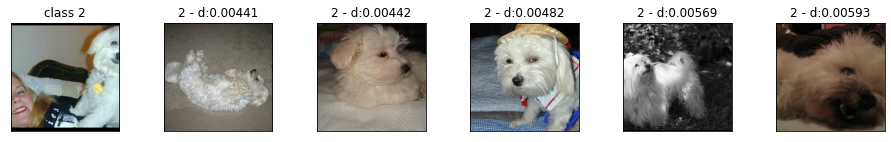

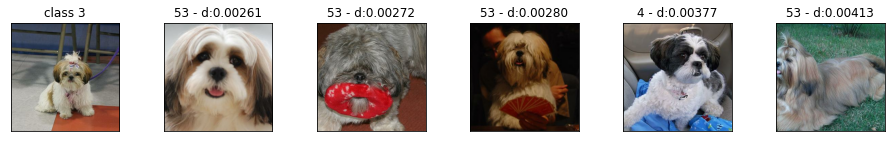

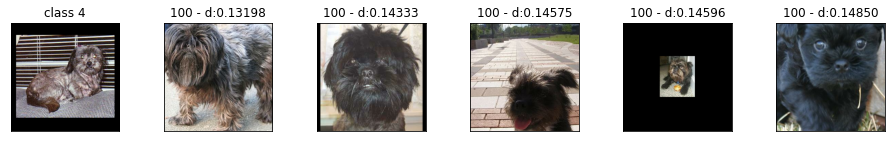

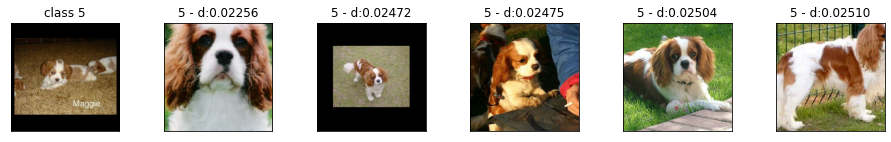

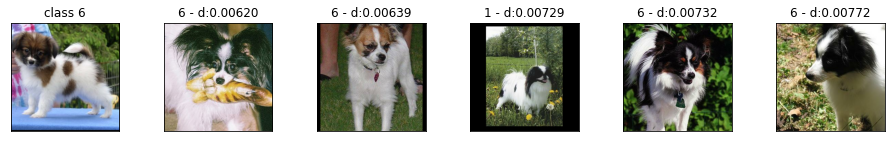

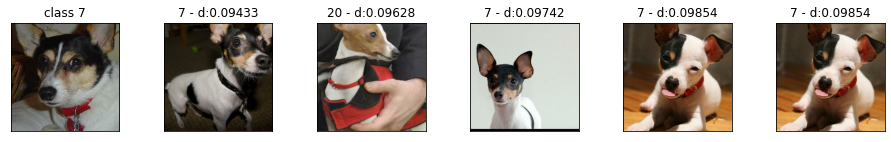

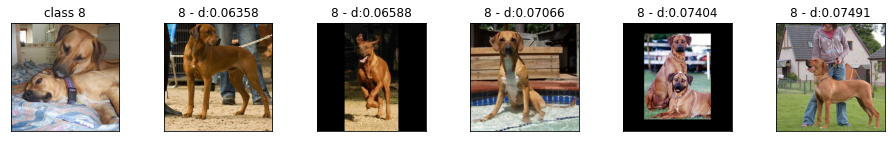

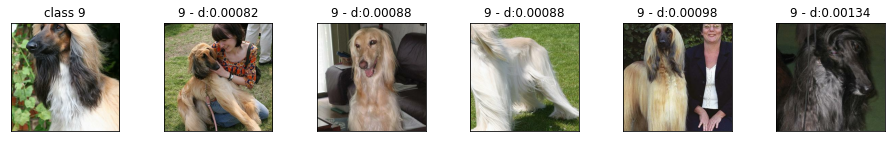

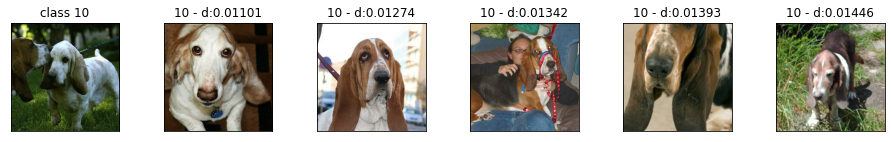

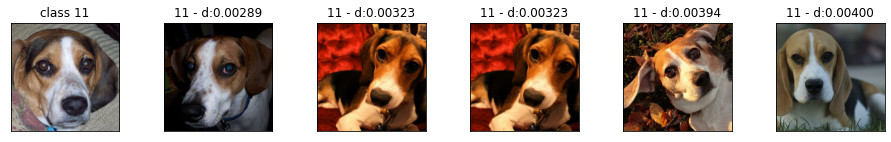

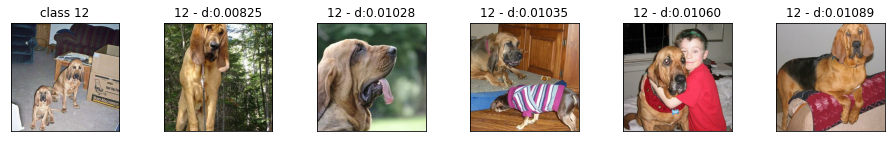

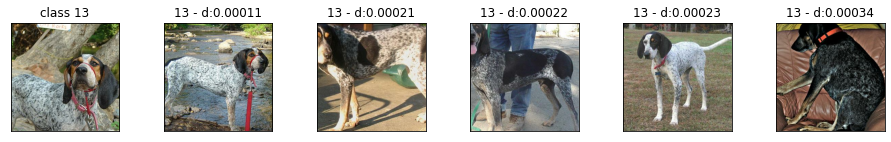

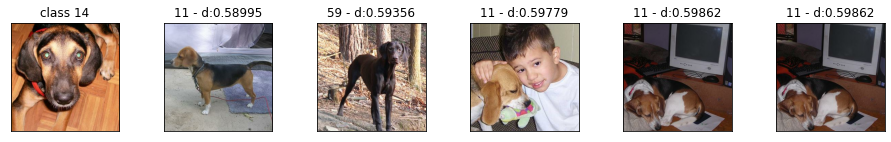

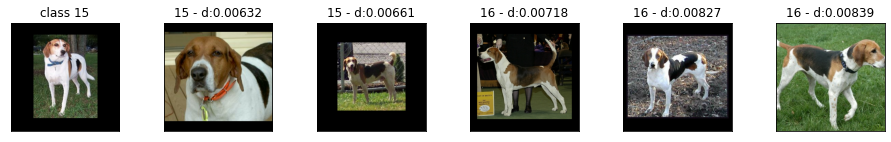

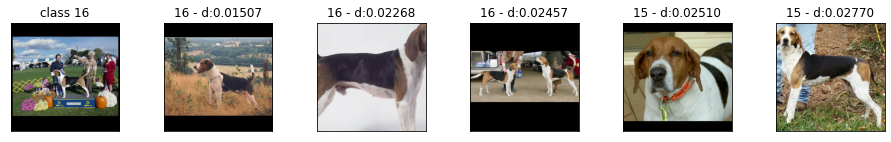

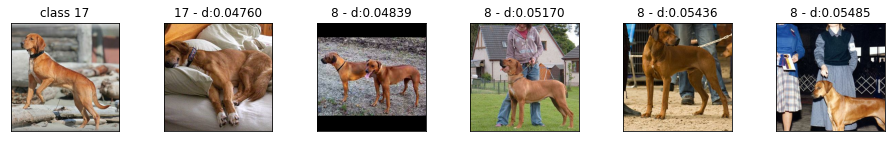

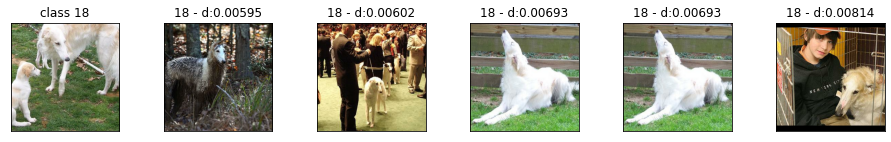

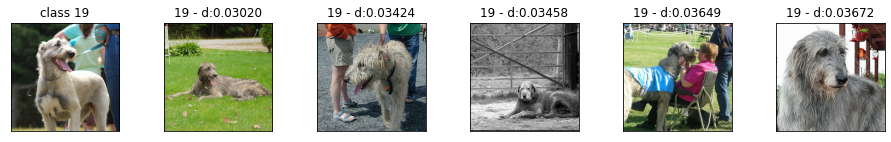

In [38]:
# re-run to test other examples
num_neighboors = 5
x_display, y_display = select_examples(x_test, y_test, range(20), 1)
# x_display = tf.image.convert_image_dtype(x_display, dtype=tf.float32)
# x_display = tf.image.

for idx in np.argsort(y_display):
    # query closest matches
    neighboors = model.single_lookup(x_display[idx], k=num_neighboors)
    # view results close by
    viz_neigbors_imgs(x_display[idx], y_display[idx], neighboors, labels=labels, fig_size=(16, 2), cmap='Greys')



## Saving

In [26]:
# save the model and the index
# FIXME move after the calibration
save_path = 'models/dogs/' #@param {type:"string"}
model.save(save_path)

INFO:tensorflow:Assets written to: models/dogs/assets
INFO:tensorflow:Assets written to: models/dogs/assets


# matching


**FIXME: enable custom thresholds**


To be able to tell if an example match a given class, we first need to `calibrate()` the model to know what is the optimal cut point. We compute several cutpoints that correspond to different performance profile:
- **match** is the optimal cutpoint that represent the best balance between precision and recall
- **very likely** is the distance cutpoint that aim to ensure a 0.99 precision.

In [ ]:
num_calibration_samples = 1000
calibration = model.calibrate(x_train[:num_calibration_samples], y_train[:num_calibration_samples], verbose=1)

Let's look how the performance metrics evolve as the distance between the sample increase. We clearly see the F1 optimial cutpoint where the precision and recall intersect.

In [ ]:
fig, ax = plt.subplots()
ax.plot(calibration['thresholds']['precision'], label='precision')
ax.plot(calibration['thresholds']['recall'], label='recall')
ax.plot(calibration['thresholds']['f1_score'], label='f1 score')
ax.legend()
ax.set_title("Metric evolution as distance increase")
ax.set_xlabel('Examples')
plt.show()

In [ ]:
calibration['thresholds']

In [ ]:
fig, ax = plt.subplots()
ax.plot(calibration['thresholds']['recall'], calibration['thresholds']['accuracy'])
ax.set_title("Precision recall curve")
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.show()

# Evaluation
We evaluate our model ability to accurately match new examples using our calibrated threshold by testing how many examples from the test sets are correctly matched. The example which have a distance above the cutoff are excluded and labeled as unknown.

The evaluation below reports 

In [ ]:
metrics = model.evaluate_matching(x_test, y_test)

# match

Let's now match a 100 examples to see how you can use the `match()` function in practice. `match()` return you what class the example belong to based of the content of the index and allows to use your model to make prediction on an unbounded, added after training, classes!

Note: `match()` return -1 by default when the distance between the submited example and any point of the index is above the distance cutpoint.

In [ ]:
num_matches = 10

matches = model.match(x_test[:num_matches], cutpoint='optimal')
rows = []
for idx, match in enumerate(matches):
    rows.append([match, y_test[idx], match == y_test[idx]])
print(tabulate(rows, headers=['Predicted', 'True', 'correct']))

## confusion matrix
Let's select a few hundreds samples for each class in the test set to plot the confusion matrix for a few

**note** `tf.math.confusion_matrix` doesn't support negative class so we are going to use **10 as our unknown class**

In [ ]:
num_example_per_class = 1000
cutpoint = 'optimal'  #@param ["optimal", "very_likely", "likely", "optimistic"]

x_confusion, y_confusion = select_examples(x_test, y_test, range(10), num_example_per_class)

matches = model.match(x_confusion, cutpoint=cutpoint, no_match_label=10)
confusion_matrix(matches, y_confusion, labels=labels, title='Confusin matrix for cutpoint:%s' % cutpoint)

# Index information

Following `model.summary()` you can get information about the index configuration and its performance using `index_summary()`.

In [ ]:
model.index_summary()

# Saving and reloading
Saving and reloading the model works as you would expected: 
- `model.save(path)`: save the model and the index on disk (`save_index=False`). By default the index is compressed - can be disabled by setting `compressed=False`
- `model = tf.keras.model.load_model(path)` reload the model. To reload the index you then need to call model.load_index(path)
- `model.save_index(path)` and `model.load_index(path)` allows to save/reload an index indenpendly of saving/loading a model if need to be


## Reloading

In [ ]:
# reload the model
reloaded_model = load_model(save_path)
# reload the index
reloaded_model.load_index(save_path)

In [ ]:
#check the index is back
reloaded_model.index_summary()

## Query reloaded model
Querying the reloaded model with its reload index works as expected

In [ ]:
# re-run a query on the loaded model
num_neighboors = 5
x_display, y_display = select_examples(x_test, y_test, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 1)

for idx in np.argsort(y_display):
    # query closest matches
    neighboors = reloaded_model.single_lookup(x_display[idx], k=num_neighboors)

    # view results close by
    viz_neigbors_imgs(x_display[idx], y_display[idx], neighboors, labels=labels, fig_size=(16, 2), cmap='Greys')